In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# %matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
from shell.fleet.comm_constraints import *
import seaborn as sns
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_19572/170371416.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [12]:
def cal_mean_and_error(df, keys=None, metric=None,
                      error_type="sem"):
   if keys is None:
      keys = ["algo", "use_contrastive"]
   if metric is None:
      metric = "final_acc"
   keys += ["dataset"]
   m = df.groupby(keys)[
         metric].mean()
   if error_type == "sem":
      stderr = df.groupby(keys)[metric].sem()
   else:
      stderr = df.groupby(keys)[metric].std()
   df = pd.DataFrame(m).reset_index()
   df[metric + "_error"] = stderr.values
   return df


In [13]:
def process_recv_df(df, error_type='std'):
    regex = r'^(?P<algo>modular|monolithic).*comm_freq_(?P<comm_freq>\d+)_num_queries_(?P<num_queries>\d+)$'

    df = df[df['use_contrastive'] == False]
    

    df = cal_mean_and_error(df, error_type=error_type)
    # Extract and assign the new columns
    df[['algo', 'comm_freq', 'num_queries']] = df['algo'].str.extract(regex)

    # Convert 'comm_freq' and 'num_queries' to integer
    df['comm_freq'] = df['comm_freq'].astype(int)
    df['num_queries'] = df['num_queries'].astype(int)

    num_epochs = 100
    df['num_comms_per_task'] = num_epochs // df['comm_freq'] - 1
    df['comm_freq'] = df['num_comms_per_task'].astype(int)
    
    df['data_pt_size'] = df.apply(
        lambda x: compute_data_pt_size(dataset=x['dataset']),
        axis=1
    )

    no_neighbors = 5

    df['comm_cost'] = df.apply(
        lambda x: compute_receiver_cost(x['num_queries'], no_neighbors, x['data_pt_size'], x['comm_freq']),
        axis=1
    )

    df['log_comm_cost'] = np.log(df['comm_cost'])

    df['algo'] = df['algo'].apply(lambda x: x + ' data')

    print(df['num_queries'].unique(), df['comm_freq'].unique())

    return df


In [14]:
def process_fedavg_df(df, error_type='std'):
    regex = r'^(?P<algo>modular|monolithic).*comm_freq_(?P<comm_freq>\d+)$'

    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, error_type=error_type)
    # Extract and assign the new columns
    df[['algo', 'comm_freq']]= df['algo'].str.extract(regex)

    # # Convert 'comm_freq' and 'num_queries' to integer
    df['comm_freq'] = df['comm_freq'].astype(int)
    # # we have comm_freq = num_epochs // (num_comms_per_task + 1)
    num_epochs = 100
    df['num_comms_per_task'] = num_epochs // df['comm_freq']
    df['comm_freq'] = df['num_comms_per_task'].astype(int)


    df['model_size'] = df.apply(
        lambda x: compute_mlp_model_size(layer_size=64, num_modules=4) if x['dataset'] != 'cifar100' else compute_cnn_model_size(),
        axis=1
    )

    df['comm_cost'] = df.apply(
        lambda x: compute_fedavg_cost(x['model_size'], x['comm_freq']),
        axis=1
    )


    df['log_comm_cost'] = np.log(df['comm_cost'])
    df['algo'] = df['algo'].apply(lambda x: x + ' FedAvg')
    return df

In [15]:
def process_vanilla_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, error_type=error_type)
    df['algo'] = df['algo'].apply(lambda x: x + ' (baseline)')
    df['log_comm_cost'] = 0.0
    df['comm_cost'] = 0.0
    df['comm_freq'] = 0
    return df

In [16]:
def process_modmod_df(df, error_type='std'):
    df = df[df['use_contrastive'] == False]
    df = cal_mean_and_error(df, error_type=error_type)

    regex = r'^(?P<algo>modular).*num_shared_modules_(?P<num_shared_modules>\d+)'
    df[['algo', 'num_shared_modules']]= df['algo'].str.extract(regex)

    df['num_shared_modules'] = df['num_shared_modules'].astype(int)

    df['comm_cost'] = df.apply(
        lambda x: compute_mlp_model_size(layer_size=64, num_modules=x['num_shared_modules']) if x['dataset'] != 'cifar100' else compute_cnn_model_size(num_modules=x['num_shared_modules']),
        axis=1
    )


    df['log_comm_cost'] = np.log(df['comm_cost'])
    df['algo'] = df['algo'].apply(lambda x: 'modmod')
    return df


In [17]:
error_type = 'sem'
# metric = 'auc'
metric = 'final_acc'

In [18]:
recv_df = pd.read_csv('budget_experiment_results/jorge_setting_recv_variable_shared_memory_size.csv')
recv_df = process_recv_df(recv_df, error_type=error_type)

[20 10 30] [ 5 10  1]


In [19]:
fed_df = pd.read_csv('budget_experiment_results/jorge_setting_fedavg.csv')
fed_df = process_fedavg_df(fed_df, error_type=error_type)
fed_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,comm_freq,num_comms_per_task,model_size,comm_cost,log_comm_cost
0,modular FedAvg,False,cifar100,0.656125,0.002136,10,10,90200,902000,13.712370
1,modular FedAvg,False,combined,0.805023,0.004826,10,10,16640,166400,12.022150
2,modular FedAvg,False,fashionmnist,0.931717,0.003734,10,10,16640,166400,12.022150
3,modular FedAvg,False,kmnist,0.800666,0.003870,10,10,16640,166400,12.022150
4,modular FedAvg,False,mnist,0.939393,0.001560,10,10,16640,166400,12.022150
5,modular FedAvg,False,cifar100,0.657869,0.001991,1,1,90200,90200,11.409785
6,modular FedAvg,False,combined,0.888648,0.003593,1,1,16640,16640,9.719565
7,modular FedAvg,False,fashionmnist,0.931692,0.003764,1,1,16640,16640,9.719565
8,modular FedAvg,False,kmnist,0.800577,0.003869,1,1,16640,16640,9.719565
9,modular FedAvg,False,mnist,0.939397,0.001556,1,1,16640,16640,9.719565


In [20]:
vanilla_df = pd.read_csv('experiment_results/vanilla_jorge_setting_basis_no_sparse.csv')
vanilla_df = process_vanilla_df(vanilla_df, error_type=error_type)
vanilla_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,log_comm_cost,comm_cost,comm_freq
0,modular (baseline),False,cifar100,0.700353,0.001357,0.0,0.0,0
1,modular (baseline),False,combined,0.885849,0.003560,0.0,0.0,0
2,modular (baseline),False,fashionmnist,0.928013,0.003087,0.0,0.0,0
3,modular (baseline),False,kmnist,0.806317,0.003094,0.0,0.0,0
4,modular (baseline),False,mnist,0.934668,0.002005,0.0,0.0,0
5,monolithic (baseline),False,cifar100,0.631084,0.003176,0.0,0.0,0
6,monolithic (baseline),False,combined,0.865895,0.003669,0.0,0.0,0
7,monolithic (baseline),False,fashionmnist,0.924673,0.003335,0.0,0.0,0
8,monolithic (baseline),False,kmnist,0.782273,0.003078,0.0,0.0,0
9,monolithic (baseline),False,mnist,0.919588,0.002693,0.0,0.0,0


In [21]:
modmod_df = pd.read_csv('budget_experiment_results/modmod.csv')
modmod_df = process_modmod_df(modmod_df, error_type)
modmod_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,num_shared_modules,comm_cost,log_comm_cost
0,modmod,False,combined,0.895478,0.003131,1,4160,8.333270
1,modmod,False,combined,0.893199,0.003243,2,8320,9.026418
2,modmod,False,combined,0.895543,0.003232,3,12480,9.431883
3,modmod,False,combined,0.894780,0.003200,4,16640,9.719565
4,modmod,False,combined,0.896496,0.003002,1,4160,8.333270
5,modmod,False,cifar100,0.727209,0.001064,1,22550,10.023490
6,modmod,False,fashionmnist,0.932812,0.003975,1,4160,8.333270
7,modmod,False,kmnist,0.818337,0.002693,1,4160,8.333270
8,modmod,False,mnist,0.940794,0.001804,1,4160,8.333270
9,modmod,False,cifar100,0.731717,0.001366,2,45100,10.716638


In [22]:
df = pd.concat([recv_df, fed_df, vanilla_df, modmod_df])

In [31]:
import matplotlib.pyplot as plt

def plot(df, metric, colormap, markermap, include_err=False):
    datasets = df['dataset'].unique()
    algos = df['algo'].unique()
    fig, ax = plt.subplots(1, len(datasets), figsize=(40, 10))
    if len(datasets) == 1:
        ax = [ax]

    handles, labels = [], []
    error_metric = metric + '_error'
    for i, dataset in enumerate(sorted(datasets)[::-1]):
        d_df = df[df['dataset'] == dataset]
        for algo in sorted(algos):  # Sorting for consistent plotting
            subset = d_df[d_df['algo'] == algo]
            if 'baseline' in algo:
                # Plot dashed horizontal line for each baseline
                mean_value = subset[metric].mean()
                line = ax[i].axhline(y=mean_value, color=colormap[algo], label=algo, linewidth=2.5, linestyle='--')
                if algo not in labels:  # Avoid duplicate labels in the legend
                    handles.append(line)
                    labels.append(algo)
            else:
                err = subset[error_metric].values  # Assuming the DataFrame contains error values

                if include_err:
                    errorbar = ax[i].errorbar(subset['log_comm_cost'], subset[metric],
                                yerr=err, fmt='o', color=colormap[algo], label=algo,
                                markersize=10, alpha=0.8, elinewidth=2,
                                marker=markermap[algo])
                else:
                    errorbar = ax[i].scatter(subset['log_comm_cost'], subset[metric],
                              color=colormap[algo], label=algo, s=150, alpha=0.8,
                              marker=markermap[algo])
                if algo not in labels:  # Avoid duplicate labels in the legend
                    handles.append(errorbar)
                    labels.append(algo)



        ax[i].set_title(f'{dataset}', fontsize=20)
        ax[i].tick_params(axis='x', labelsize=16)
        ax[i].tick_params(axis='y', labelsize=16)
        ax[i].grid(True, which='major', linestyle='--', alpha=0.5)

    latex_metric = metric.replace('_', '\_')
    # fig.suptitle(r'Comparing methods under different budget $\mathsf{'+latex_metric+'}$', fontsize=30, weight='bold')
    fig.suptitle(r'Comparing methods under different budget', fontsize=30, weight='bold')
    fig.text(0.5, 0.02, 'Log(communication cost)', ha='center', va='center', fontsize=20, weight='bold')
    # fig.text(0.02, 0.5, metric, ha='center', va='center', rotation='vertical', fontsize=20, weight='bold')
    fig.text(0.02, 0.5, "Final Avg Test Accuracy", ha='center', va='center', rotation='vertical', fontsize=20, weight='bold')
    fig.legend(handles, labels, loc='lower right', fontsize=20, frameon=True, bbox_to_anchor=(1.1, 0.0))
    plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    
    plt.savefig("Figures/budget.pdf", bbox_inches="tight")

# Usage of this function will require a DataFrame `df` with columns 'dataset', 'algo', 'log_comm_cost', and the specific 'metric'.
# You will also need to provide a `colormap` dictionary mapping each algorithm to a color.


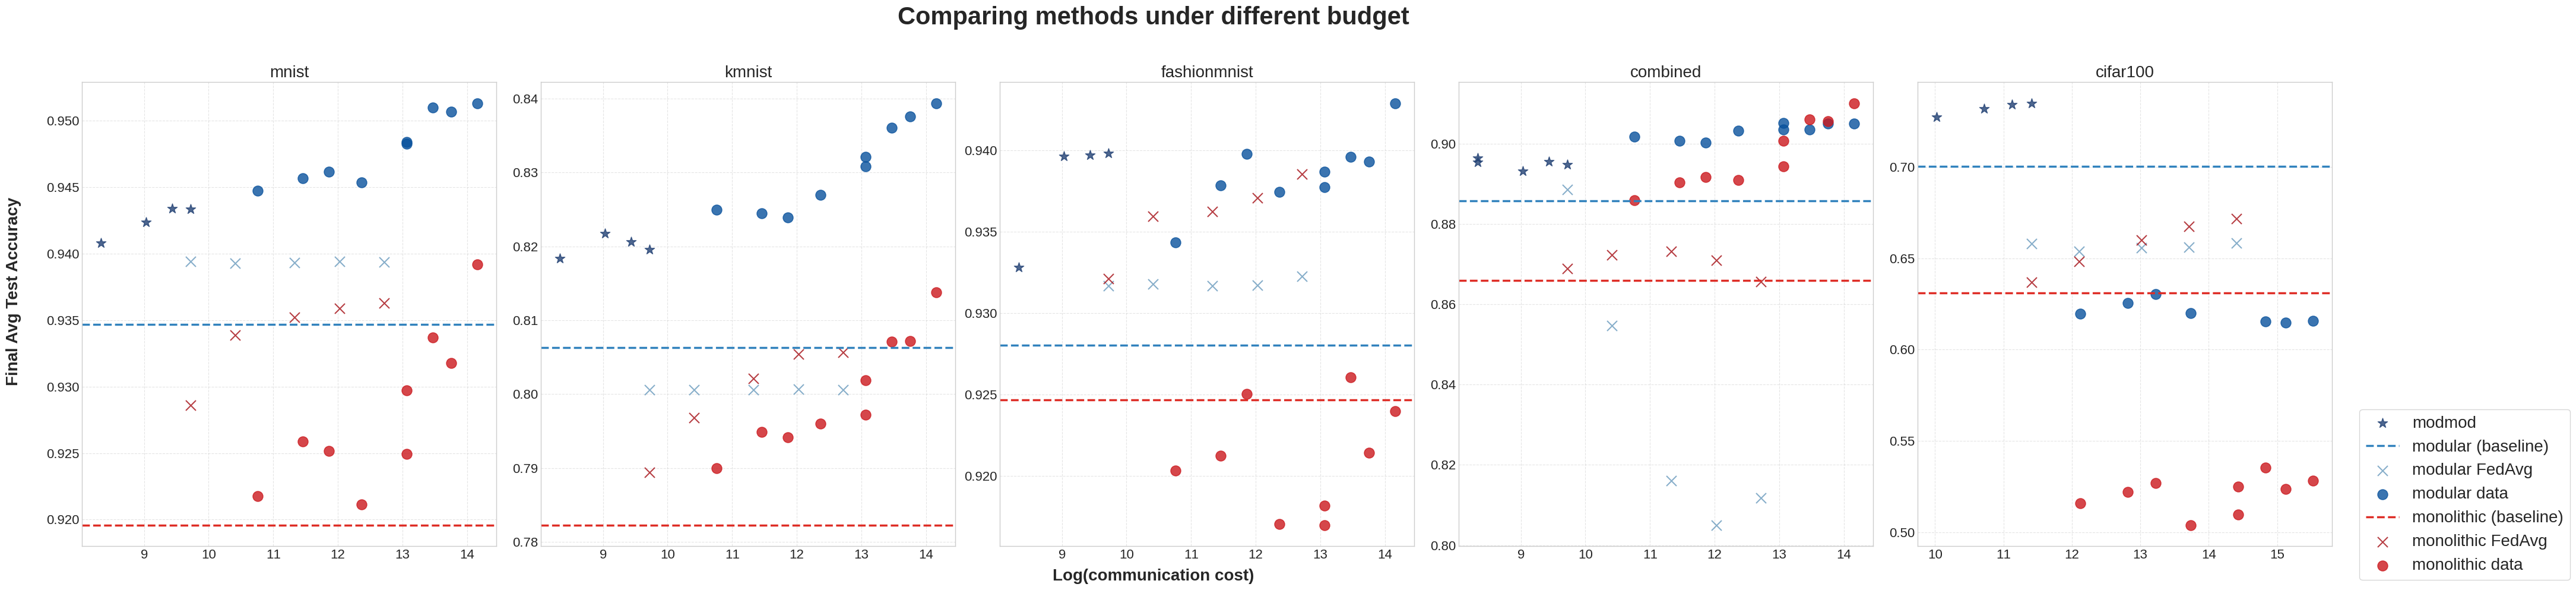

In [32]:


algos = df['algo'].unique()


colormap = {
   'modular_use_contrastive:False': '#3182bd',
   'monolithic_use_contrastive:False': '#de2d26',
   'modular_modmod_use_contrastive:False':  '#214073',  # Corrected key
   'modular_fedavg_use_contrastive:False': '#6a9bbd',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': '#a50f15',  # Changed key format
   'modular_recv_use_contrastive:False': '#08519c',  # Changed key format
   'monolithic_recv_use_contrastive:False': '#cb181d',  # Changed key format
}

remap_name = {
   'modular_use_contrastive:False': 'modular (baseline)',
   'monolithic_use_contrastive:False': 'monolithic (baseline)',
   'modular_modmod_use_contrastive:False':  'modmod',  # Corrected key
   'modular_fedavg_use_contrastive:False': 'modular FedAvg',  # Changed key format
   'monolithic_fedavg_use_contrastive:False': 'monolithic FedAvg',  # Changed key format
   'modular_recv_use_contrastive:False': 'modular data',  # Changed key format
   'monolithic_recv_use_contrastive:False': 'monolithic data',  # Changed key format
}

r_colormap = {
    remap_name[k]: v for k, v in colormap.items()
}

markermap = {
    'modular data': 'o',
    'monolithic data': 'o',

    'modular FedAvg': 'x',
    'monolithic FedAvg': 'x',

    'modmod': '*',
}

# # color_map = plt.cm.get_cmap('tab20b', num_colors)
# color_map = plt.cm.get_cmap('tab10', len(algos))
# colormap = {algo: color_map(i) for i, algo in enumerate(algos)}

plot(df, metric, r_colormap, markermap)

In [25]:
d_df = df[df['dataset'] == 'combined']
d_df = d_df[d_df['algo'] == 'modular']
d_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,comm_freq,num_queries,num_comms_per_task,data_pt_size,comm_cost,log_comm_cost,model_size,num_shared_modules


In [26]:
d_df = df[df['dataset'] == 'cifar100']
# d_df = d_df[d_df['algo'] == 'modular']
d_df

,algo,use_contrastive,dataset,final_acc,final_acc_error,comm_freq,num_queries,num_comms_per_task,data_pt_size,comm_cost,log_comm_cost,model_size,num_shared_modules
8,modular data,False,cifar100,0.615497,0.001767,5.0,30.0,5.0,3072.0,2764800.0,14.832479,NaN,NaN
13,modular data,False,cifar100,0.614884,0.002033,10.0,20.0,10.0,3072.0,3686400.0,15.120161,NaN,NaN
18,modular data,False,cifar100,0.615705,0.001900,10.0,30.0,10.0,3072.0,5529600.0,15.525626,NaN,NaN
23,modular data,False,cifar100,0.619655,0.001809,1.0,10.0,1.0,3072.0,184320.0,12.124429,NaN,NaN
28,modular data,False,cifar100,0.625458,0.002006,1.0,20.0,1.0,3072.0,368640.0,12.817576,NaN,NaN
33,modular data,False,cifar100,0.630381,0.001697,1.0,30.0,1.0,3072.0,552960.0,13.223041,NaN,NaN
38,modular data,False,cifar100,0.619995,0.001881,5.0,10.0,5.0,3072.0,921600.0,13.733867,NaN,NaN
43,monolithic data,False,cifar100,0.525112,0.001927,5.0,20.0,5.0,3072.0,1843200.0,14.427014,NaN,NaN
48,monolithic data,False,cifar100,0.509942,0.001742,10.0,10.0,10.0,3072.0,1843200.0,14.427014,NaN,NaN
53,monolithic data,False,cifar100,0.535559,0.001818,5.0,30.0,5.0,3072.0,2764800.0,14.832479,NaN,NaN


In [27]:
# find max row of auc for d_df
max_row = d_df[d_df[metric] == d_df[metric].max()]
max_row

,algo,use_contrastive,dataset,final_acc,final_acc_error,comm_freq,num_queries,num_comms_per_task,data_pt_size,comm_cost,log_comm_cost,model_size,num_shared_modules
17,modmod,False,cifar100,0.734803,0.001387,NaN,NaN,NaN,NaN,90200.0,11.409785,NaN,4.0
